In [1]:
import os
os.environ["JAVA_HOME"] = "C:\\jdk-22.0.2"
os.environ["SPARK_HOME"] = "C:\\spark-3.5.2-bin-hadoop3\\spark-3.5.2-bin-hadoop3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_PYTHON"] = "python"

In [2]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder.appName("Introducao Spark").getOrCreate()

In [4]:
df_spark = spark.read.option("header","true")\
          .option("encoding", "utf-8")\
          .option("sep",";")\
          .option('inferSchema', 'true')\
          .csv('C:\\01-FaculdadeSemestreAtual\\Processamento_de_Dados_Massivos\\reclamacoes_contexto.csv')


In [5]:
# Tipos das Colunas
df_spark.printSchema()

root
 |-- DataExtracao: date (nullable = true)
 |-- SOLICITAÇÕES: integer (nullable = true)
 |-- Ano: integer (nullable = true)
 |-- Mês: integer (nullable = true)
 |-- AnoMês: timestamp (nullable = true)
 |-- UF: string (nullable = true)
 |-- Cidade: string (nullable = true)
 |-- CO_MUNICIPIO: string (nullable = true)
 |-- CanalEntrada: string (nullable = true)
 |-- Condição: string (nullable = true)
 |-- TipoAtendimento: string (nullable = true)
 |-- Serviço: string (nullable = true)
 |-- Marca: string (nullable = true)
 |-- Assunto: string (nullable = true)
 |-- Problema: string (nullable = true)
 |-- Linha: integer (nullable = true)



In [6]:
# Vendo as 5 primeiras linhas do DF
df_spark.limit(5).show()

+------------+------------+----+---+-------------------+---+----------+------------+------------+-------------+--------------------+-------+------+--------------------+--------------------+-----+
|DataExtracao|SOLICITAÇÕES| Ano|Mês|             AnoMês| UF|    Cidade|CO_MUNICIPIO|CanalEntrada|     Condição|     TipoAtendimento|Serviço| Marca|             Assunto|            Problema|Linha|
+------------+------------+----+---+-------------------+---+----------+------------+------------+-------------+--------------------+-------+------+--------------------+--------------------+-----+
|  2018-04-23|           1|2015|  1|2015-01-01 00:00:00| DF|  Brasília|     5300108|         SIC|Reencaminhada|Pedido de Informação| Outros|Outros|       NÃO APLICÁVEL|                 SIC|    1|
|  2018-04-23|           1|2015|  1|2015-01-01 00:00:00| AC|Rio Branco|     1200401|Fale Conosco|         Nova|          Reclamação|   STFC|    OI|Bloqueio ou Suspe...|Bloqueio ou suspe...|    2|
|  2018-04-23|      

# Distribuição Temporal: Quantas reclamações foram registradas por ano? Existe uma tendência de aumento ou diminuição no número de solicitações ao longo dos anos?

In [7]:
reclamacoes_por_ano = df_spark.groupBy("Ano").agg(count("SOLICITAÇÕES").alias("total_reclamacoes")).orderBy("Ano")
reclamacoes_por_ano.show()

+----+-----------------+
| Ano|total_reclamacoes|
+----+-----------------+
|2015|          3434077|
|2016|          3364179|
|2017|          2953594|
|2018|          2590318|
|2019|          2617122|
|2020|          2351831|
|2021|          1866754|
|2022|          1502909|
|2023|          1173279|
|2024|           659473|
+----+-----------------+



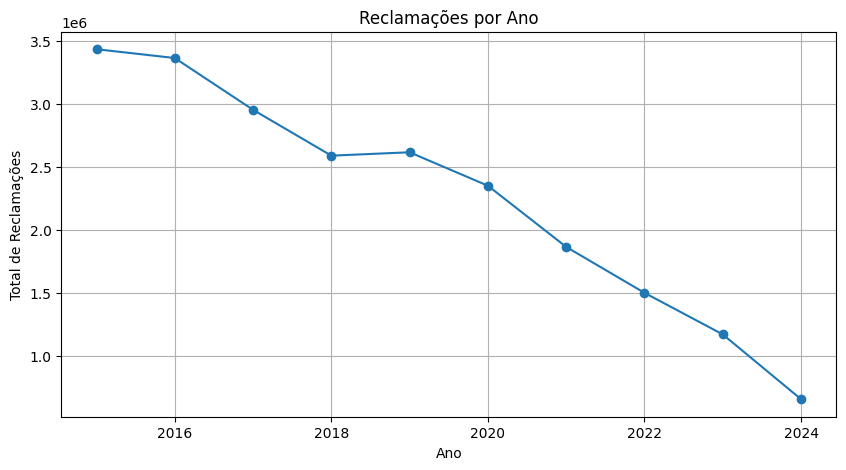

In [8]:
# Conversão para Pandas
reclamacoes_por_ano_pd = reclamacoes_por_ano.toPandas()

# Plotando
plt.figure(figsize=(10, 5))
plt.plot(reclamacoes_por_ano_pd['Ano'], reclamacoes_por_ano_pd['total_reclamacoes'], marker='o')
plt.title('Reclamações por Ano')
plt.xlabel('Ano')
plt.ylabel('Total de Reclamações')
plt.grid()
plt.show()


# Reclamações por Região: Qual é o estado (UF) com o maior número de reclamações? Como os diferentes estados se comparam em relação ao volume de solicitações?

In [9]:
reclamacoes_por_estado = df_spark.groupBy("UF").agg(count("SOLICITAÇÕES").alias("total_reclamacoes")).orderBy(col("total_reclamacoes").desc())
reclamacoes_por_estado.show()

+---+-----------------+
| UF|total_reclamacoes|
+---+-----------------+
| SP|          6687269|
| MG|          3144790|
| RJ|          2966678|
| BA|          1405669|
| PR|          1262970|
| RS|          1121924|
| GO|           796431|
| SC|           768177|
| PE|           701018|
| CE|           565352|
| DF|           545542|
| ES|           389202|
| PA|           312643|
| PB|           228168|
| MA|           219660|
| SE|           190860|
| MS|           187233|
| MT|           183536|
| RN|           170767|
| AM|           166204|
+---+-----------------+
only showing top 20 rows



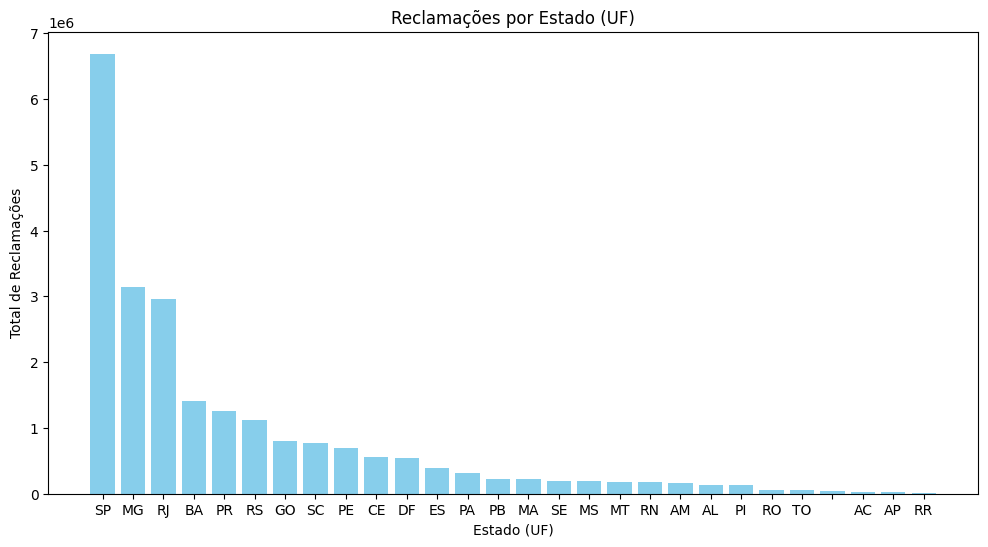

In [10]:
# Filtrando valores nulos
reclamacoes_por_estado_filtered = reclamacoes_por_estado.na.drop()

# Convertendo para Pandas
reclamacoes_por_estado_pd = reclamacoes_por_estado_filtered.toPandas()

# Plotando
plt.figure(figsize=(12, 6))
plt.bar(reclamacoes_por_estado_pd['UF'], reclamacoes_por_estado_pd['total_reclamacoes'], color='skyblue')
plt.title('Reclamações por Estado (UF)')
plt.xlabel('Estado (UF)')
plt.ylabel('Total de Reclamações')
plt.xticks(rotation=0)
plt.show()


# Análise por Canal de Entrada: Qual o canal de entrada mais utilizado pelos usuários para registrar suas reclamações? Há alguma diferença no tipo de problema relatado dependendo do canal de entrada?

In [11]:
canal_entrada = df_spark.groupBy("CanalEntrada").agg(count("SOLICITAÇÕES").alias("total_reclamacoes")).orderBy(col("total_reclamacoes").desc())
canal_entrada.show()

# Diferença de problemas por canal
problemas_por_canal = df_spark.groupBy("CanalEntrada", "Problema").agg(count("SOLICITAÇÕES").alias("total_reclamacoes"))
problemas_por_canal.show()

+-------------------+-----------------+
|       CanalEntrada|total_reclamacoes|
+-------------------+-----------------+
|        Call Center|         11618015|
|       Fale Conosco|          4520508|
|        Usuário WEB|          2944626|
|         Mobile App|          2138460|
|   Aplicativo Móvel|          1211841|
|Atendimento Pessoal|            63081|
|                SEI|             8300|
|    Correspondência|             4009|
|                SIC|             3507|
|                Fax|              755|
|             E-mail|              264|
|                TTS|              154|
|                SOA|               16|
+-------------------+-----------------+

+-------------------+--------------------+-----------------+
|       CanalEntrada|            Problema|total_reclamacoes|
+-------------------+--------------------+-----------------+
|       Fale Conosco|          Legislação|              263|
|    Correspondência|Rádio Pirata / Cl...|               25|
|    Correspon

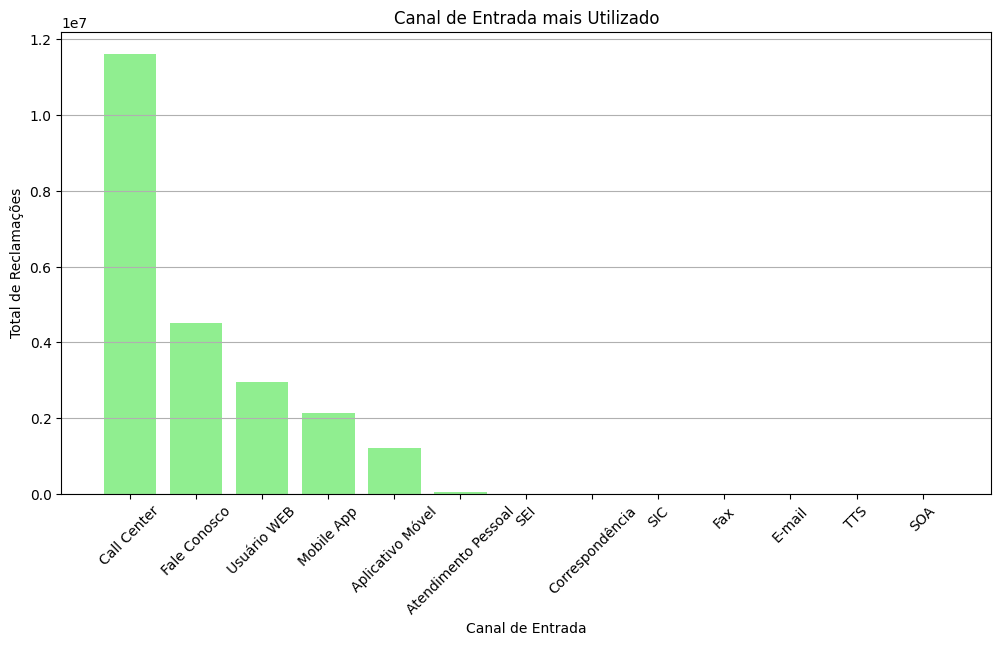

In [12]:
canal_entrada_pd = canal_entrada.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(canal_entrada_pd['CanalEntrada'], canal_entrada_pd['total_reclamacoes'], color='lightgreen')
plt.title('Canal de Entrada mais Utilizado')
plt.xlabel('Canal de Entrada')
plt.ylabel('Total de Reclamações')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


# Análise de Problemas e Assuntos: Quais são os problemas e assuntos mais comuns relatados pelos usuários? Existe algum padrão ou concentração de reclamações em um determinado serviço ou marca?

In [13]:
problemas_comuns = df_spark.groupBy("Problema").agg(count("SOLICITAÇÕES").alias("total_reclamacoes")).orderBy(col("total_reclamacoes").desc())
problemas_comuns.show()


+--------------------+-----------------+
|            Problema|total_reclamacoes|
+--------------------+-----------------+
|Cobrança em desac...|          1993758|
|Cobrança após can...|          1058360|
|Cobrança de servi...|           797807|
|Bloqueio ou suspe...|           646670|
|Cobrança indevida...|           582876|
|Cancelamento soli...|           554835|
|Linha muda ou sem...|           547249|
|Cancelamento inde...|           509735|
|Sem Conexão de dados|           469550|
|Lentidão ou veloc...|           466163|
|Não cumprimento d...|           446257|
|Instalação ou hab...|           445764|
|Não consegue alte...|           368458|
|Cobrança de valor...|           347635|
|Cobrança de servi...|           336636|
|Ressarcimento de ...|           330242|
|Cobrança de servi...|           327060|
|Reparo não realiz...|           289874|
|Persistência do p...|           288223|
|Consumidor não co...|           272960|
+--------------------+-----------------+
only showing top

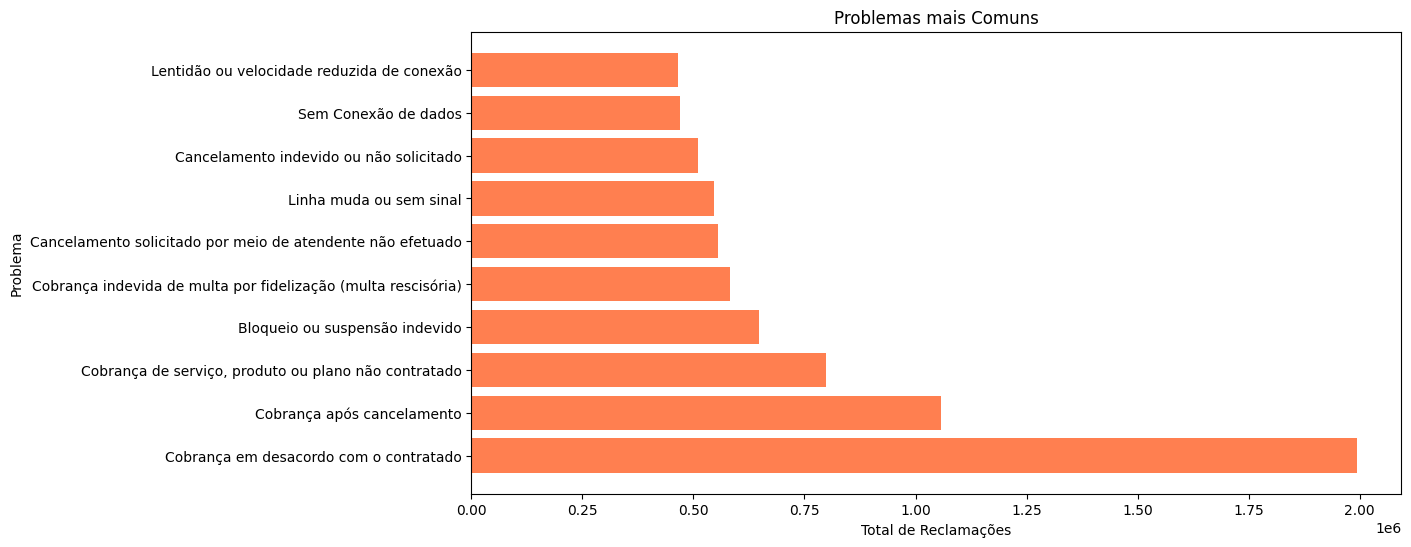

In [14]:
problemas_comuns_pd = problemas_comuns.limit(10).toPandas()

plt.figure(figsize=(12, 6))
plt.barh(problemas_comuns_pd['Problema'], problemas_comuns_pd['total_reclamacoes'], color='coral')
plt.title('Problemas mais Comuns')
plt.xlabel('Total de Reclamações')
plt.ylabel('Problema')
plt.show()


# Reclamações por Tipo de Atendimento: Quais tipos de atendimento são mais solicitados? Há algum tipo de atendimento que é mais eficaz, resultando em menos solicitações subsequentes?

In [15]:
atendimentos_comuns = df_spark.groupBy("TipoAtendimento").agg(count("SOLICITAÇÕES").alias("total_reclamacoes")).orderBy(col("total_reclamacoes").desc())
atendimentos_comuns.show()

+--------------------+-----------------+
|     TipoAtendimento|total_reclamacoes|
+--------------------+-----------------+
|          Reclamação|         22125403|
|Pedido de Informação|           313901|
|            Denúncia|            33022|
|    Denúncia Anônima|            17601|
|Outras Manifestações|             9892|
|              Elogio|             7351|
|            Sugestão|             6056|
|    Denúncia ANÔNIMA|              310|
+--------------------+-----------------+



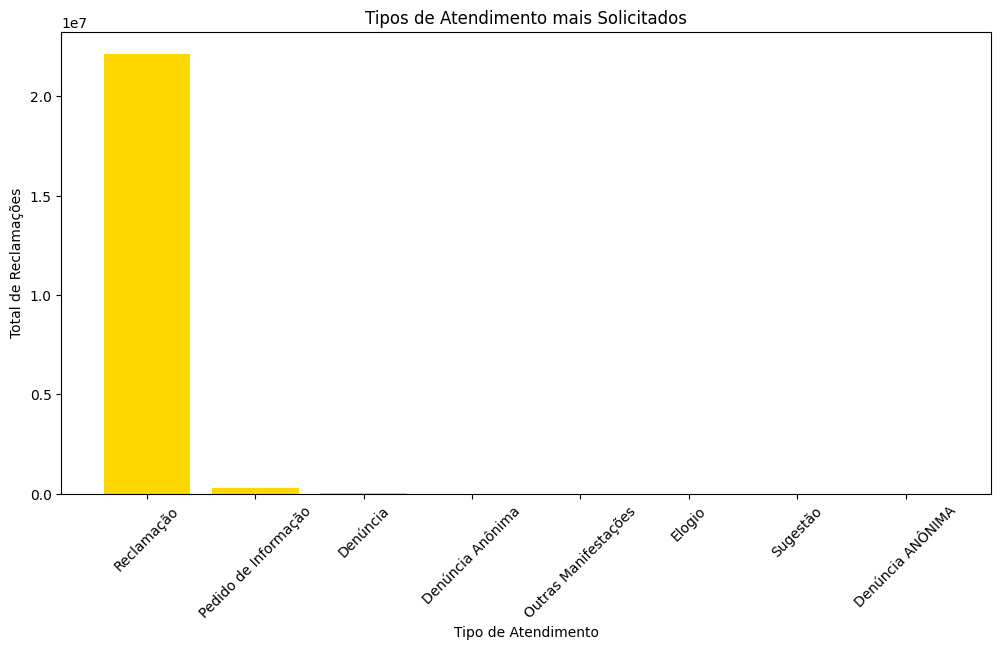

In [16]:
atendimentos_comuns_pd = atendimentos_comuns.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(atendimentos_comuns_pd['TipoAtendimento'], atendimentos_comuns_pd['total_reclamacoes'], color='gold')
plt.title('Tipos de Atendimento mais Solicitados')
plt.xlabel('Tipo de Atendimento')
plt.ylabel('Total de Reclamações')
plt.xticks(rotation=45)
plt.show()


# Análise de Cidade e Serviço: Quais são as cidades com o maior número de reclamações por serviço? Existe alguma cidade que se destaque de forma positiva ou negativa em relação ao atendimento prestado?

In [17]:
reclamacoes_por_cidade_servico = df_spark.groupBy("Cidade", "Serviço").agg(count("SOLICITAÇÕES").alias("total_reclamacoes")).orderBy(col("total_reclamacoes").desc())
reclamacoes_por_cidade_servico.show()


+--------------+-------+-----------------+
|        Cidade|Serviço|total_reclamacoes|
+--------------+-------+-----------------+
|     São Paulo|SMP_Pós|           661747|
|Rio de Janeiro|SMP_Pós|           445114|
|     São Paulo|    SCM|           387959|
|     São Paulo|   STFC|           294305|
|Belo Horizonte|SMP_Pós|           289810|
|     São Paulo|SMP_Pré|           284014|
|Rio de Janeiro|    SCM|           274355|
|Rio de Janeiro|   STFC|           270978|
|     São Paulo|   SeAC|           259941|
|      Salvador|SMP_Pós|           194966|
|Rio de Janeiro|   SeAC|           192328|
|      Brasília|SMP_Pós|           190961|
|Belo Horizonte|    SCM|           161971|
|Belo Horizonte|   STFC|           149285|
|      Curitiba|SMP_Pós|           144523|
|      Salvador|SMP_Pré|           141788|
|Rio de Janeiro|SMP_Pré|           137112|
|       Goiânia|SMP_Pós|           128443|
|      Salvador|    SCM|           126564|
|      Salvador|   STFC|           125400|
+----------

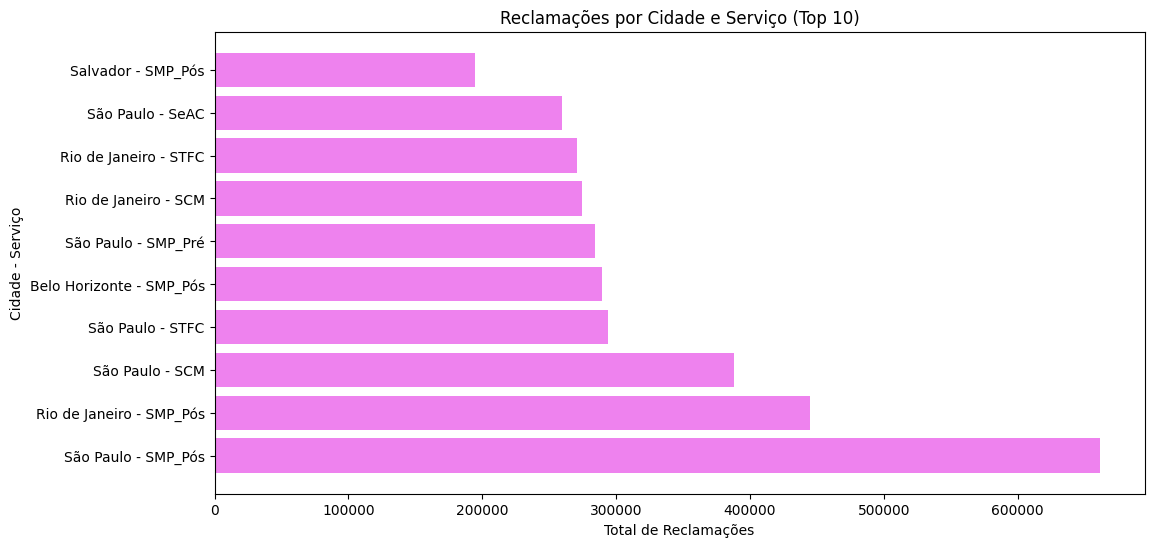

In [18]:
reclamacoes_por_cidade_servico_pd = reclamacoes_por_cidade_servico.limit(10).toPandas()  # Limitando para evitar gráfico muito cheio

plt.figure(figsize=(12, 6))
plt.barh(reclamacoes_por_cidade_servico_pd['Cidade'] + ' - ' + reclamacoes_por_cidade_servico_pd['Serviço'],
        reclamacoes_por_cidade_servico_pd['total_reclamacoes'], color='violet')
plt.title('Reclamações por Cidade e Serviço (Top 10)')
plt.xlabel('Total de Reclamações')
plt.ylabel('Cidade - Serviço')
plt.show()


# Evolução Mensal das Reclamações: Como as reclamações evoluem ao longo dos meses dentro de um mesmo ano? Existe algum período específico em que as reclamações aumentam significativamente?

In [19]:
evolucao_mensal = df_spark.groupBy("Ano", "Mês").agg(count("SOLICITAÇÕES").alias("total_reclamacoes")).orderBy("Ano", "Mês")
evolucao_mensal.show()


+----+---+-----------------+
| Ano|Mês|total_reclamacoes|
+----+---+-----------------+
|2015|  1|           180864|
|2015|  2|           221442|
|2015|  3|           310641|
|2015|  4|           282299|
|2015|  5|           297530|
|2015|  6|           304400|
|2015|  7|           342906|
|2015|  8|           316767|
|2015|  9|           305484|
|2015| 10|           294596|
|2015| 11|           287916|
|2015| 12|           289232|
|2016|  1|           304171|
|2016|  2|           293737|
|2016|  3|           328335|
|2016|  4|           278452|
|2016|  5|           272804|
|2016|  6|           278217|
|2016|  7|           274271|
|2016|  8|           297730|
+----+---+-----------------+
only showing top 20 rows



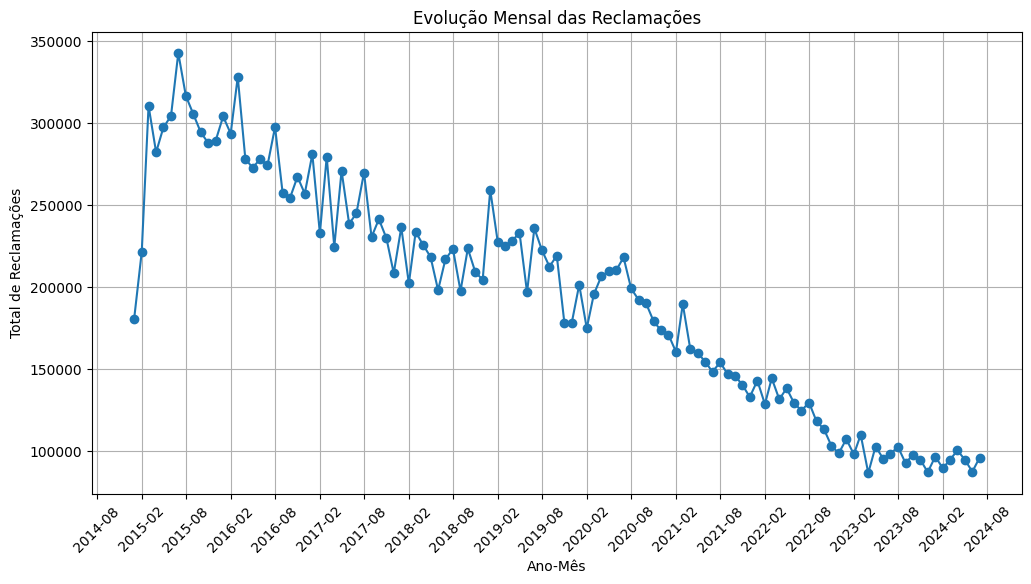

In [20]:
import matplotlib.dates as mdates

evolucao_mensal_pd = evolucao_mensal.toPandas()

# Criando a coluna 'Ano-Mês' como uma data
evolucao_mensal_pd['Ano-Mês'] = pd.to_datetime(evolucao_mensal_pd['Ano'].astype(str) + '-' + evolucao_mensal_pd['Mês'].astype(str))

plt.figure(figsize=(12, 6))
plt.plot(evolucao_mensal_pd['Ano-Mês'], evolucao_mensal_pd['total_reclamacoes'], marker='o')
plt.title('Evolução Mensal das Reclamações')
plt.xlabel('Ano-Mês')
plt.ylabel('Total de Reclamações')

# Formatando os ticks do eixo x
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Ticks a cada 6 meses
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato de data

plt.xticks(rotation=45)
plt.grid()
plt.show()
